In [5]:
import uproot4
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.stats import argus
from scipy.integrate import quad
from numpy import  log, sqrt, exp, pi, e
import multiprocessing
import os
from numba import njit
from Mat_belle.source import *

In [2]:
!pip list

Package              Version
-------------------- -----------
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
async-generator      1.10
attrs                22.2.0
awkward              1.9.0
awkward1             1.0.0
backcall             0.2.0
bleach               4.1.0
cffi                 1.15.1
comm                 0.1.4
cycler               0.11.0
dataclasses          0.8
decorator            5.1.1
defusedxml           0.7.1
entrypoints          0.4
iminuit              2.16.0
importlib-metadata   4.8.3
ipykernel            5.5.6
ipython              7.16.3
ipython-genutils     0.2.0
ipywidgets           7.8.1
jedi                 0.17.2
Jinja2               3.0.3
jsonschema           3.2.0
jupyter              1.0.0
jupyter-client       7.1.2
jupyter-console      6.4.3
jupyter-core         4.9.2
jupyterlab-pygments  0.1.2
jupyterlab-widgets   1.1.7
kiwisolver           1.3.1
llvmlite             0.36.0
MarkupSafe           2.0.1
matplotlib           3.3.4
mistune         

     fun: 3.9441427577906096
     jac: array([-3.23772430e-04, -5.77867031e-05,  1.88469887e-04,  1.09225512e-04,
        5.02586365e-04])
 message: 'Optimization terminated successfully'
    nfev: 261
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([7.99476591, 0.97916828, 1.08385348, 2.06163092, 0.0590369 ])


/gpfs/home/belle2/matrk/Mat_belle/source.py:111: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)


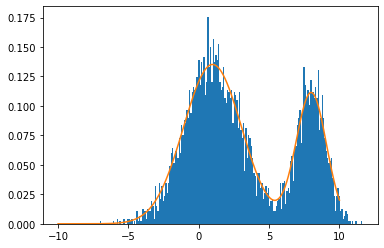

In [7]:
N = 5000
tau = 0.3
x = np.concatenate((np.random.normal(8, 1, int(N*tau)), np.random.normal(1, 2, int(N*(1-tau)))))
plt.hist(x, density=True, bins=200)
counts, bin_edges = np.histogram(x, bins=15)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
f = lambda x, mu1, mu2, s1, s2, tau: gaussian(x, mu1, s1)*tau + gaussian(x, mu2, s2)*(1-tau)
args, _ = max_bin_lik(f, bin_centers, counts, (5, 2, 1, 1, 0.5))
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, f(xx, *args)/_)

In [16]:
fname = "Mat_belle/root_/mc.root"
tupl2 = uproot4.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
mc = tupl2.arrays(library='pd')

FileNotFoundError: file not found

    'Mat_belle/root_/mc.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [18]:
fname = "Mat_belle/root_/data.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
re = tupl2.arrays(library='pd')

FileNotFoundError: file not found

    'Mat_belle/root_/data.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [14]:
!ls

echo		  last.kumac  Orbits	      sample.txt   work
example.cc	  Mat_belle   output.png      st_root.sh   x_root.txt
higz_windows.dat  orbit.gif   py	      st_root.sh~
id.pub		  orbit.png   reconstruction  try.sh


In [23]:
fname = "Mat_belle/inclusive_data.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
inc = tupl2.arrays(library='pd')

['ecm', 'rm2l', 'dsm', 'dm', 'dsp', 'dp', 'ntr', 'chxc']


In [24]:
plt.figure(figsize=(12, 6))
dat = inc[(np.abs(inc.rm2l - Lamc_m) < 0.8) & (inc.ntr <= 3)]
datt = inc[(np.abs(inc.rm2l - Lamc_m) < 0.8) & (inc.ntr > 3)]
diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), 45)
N = dat.shape[0]
plt.legend(title = f"$N = {N}$")
plt.hist(dat["rm2l"], bins=diw, alpha=0.3)
plt.hist(datt["rm2l"], bins=diw, alpha=0.3)

NameError: name 'Lamc_m' is not defined

<Figure size 864x432 with 0 Axes>

In [117]:
continuum_lam = njit(lambda x, A1, c, lam, mu, sig1: A1*c*np.exp((x-mu)*lam) + (1-A1)*gaussian(x, 2.65, sig1) )

f_lam = lambda x, A, A1, c, lam, mu, sig, sig1: A*gaussian(x, lamc_mass, sig) + (1-A)*continuum_lam(x, A1, c, lam, mu, sig1)

/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  


No handles with labels found to put in legend.


     fun: 125.00359341868983
     jac: array([ 1.06809616e-01,  1.90734863e-06,  2.86102295e-06, -8.20159912e-05,
       -9.53674316e-07, -4.40597534e-04,  8.77380371e-05])
 message: 'Optimization terminated successfully'
    nfev: 97
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([1.29678524e-05, 3.83637846e-01, 6.79414408e-02, 1.55459769e+00,
       2.05270646e-05, 2.74816167e-02, 4.91211001e-01])


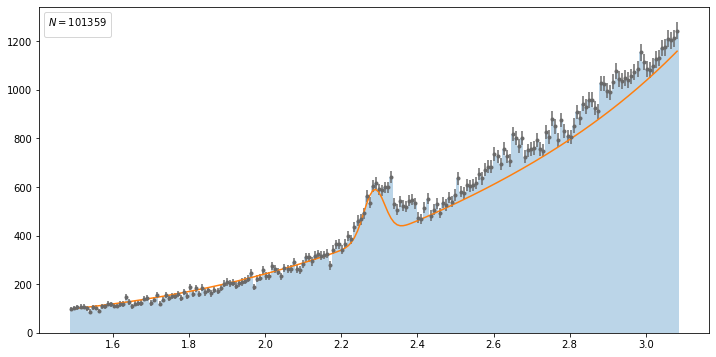

In [118]:
nbins = 200

plt.figure(figsize=(12, 6))
dat = inc[(np.abs(inc.rm2l - lamc_mass) < 0.8) & (inc.ntr <= 3) & (np.abs(inc.dm - 1.86483) < 0.02) & (np.abs(inc.dsm - 2.00685) < 0.006)]
counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
args = ( -8.91246192e-08,  3.29203741e-01,  1.31358300e-06,  1.52823827e+00,
       -2.33785575e+01,  2.16615438e-03,  2.55547321e-01)

bounds = [
    (0, 1),        # A: Amplitude of the signal component
    (0, 1),        # A1: Mixing parameter for the background
    (1e-5, 10),     # c: Scale of the background component
    (0, 10),     # lam: Exponent coefficient in the exponential
    (0, 10),     # mu: Mean of the Gaussian component
    (1e-5, 1),     # sig: Standard deviation of the signal Gaussian
    (1e-5, 1)      # sig1: Standard deviation of the background Gaussian
]

args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=bounds)

N = dat.shape[0]
norm = N/(nbins+1)

diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), nbins+1)
plt.legend(title = f"$N = {N}$")
plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
plt.hist(dat["rm2l"], bins=diw, alpha=0.3)
plt.plot(bin_centers, f_lam(bin_centers, *args)*1.5*norm/normm)

In [ ]:
path = "Mat_belle//data//"

In [ ]:
data = [re, mc]

In [ ]:
mc["chxc"] = pd.to_numeric(mc["chxc"])
mc["chlc"] = pd.to_numeric(mc["chlc"])


In [ ]:
chxc = int(mc.chxc.max())
decay_mod_taging = ["$X_c \\to D^0 p$", "$X_c \\to D^+ p \\pi^- $", "$X_c \\to D^{*0} p$", "$X_c \\to D^{*+} p \\pi^-$", "$X_c \\to \\Lambda_c^- \\pi^- \\pi^+$"]
decay_mod_tag = {"\\Lambda \\nu_l l": [lambda x: x <= 2, "L_nu_l"], "\\Lambda \\pi" : [lambda x: x == 3, "L_pi"], "p K \\pi" : [lambda x: x == 5, "p_k_pi"]}

In [ ]:
D_star_0_gamm_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.010) & (dt.chach == 2) & (dt.chxc == 3)
D_star_0_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & (dt.chach == 1) & (dt.chxc == 3)
D_star_pm_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & ((dt.chach == 1) | (dt.chach == 2)) & (dt.chxc == 4)
D_star_mask = lambda dt: D_star_0_gamm_mask(dt) | D_star_0_pi_mask(dt) | D_star_pm_pi_mask(dt) | (dt.chxc == 1) | (dt.chxc == 2)
Lambda_c_mass_mask = lambda dt: np.abs(dt.mlc) < 0.015 
Privalov_cut = lambda dt: (np.abs(dt.p) < 0.05) & (np.abs(dt.e - dt.ecm) < 0.05)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


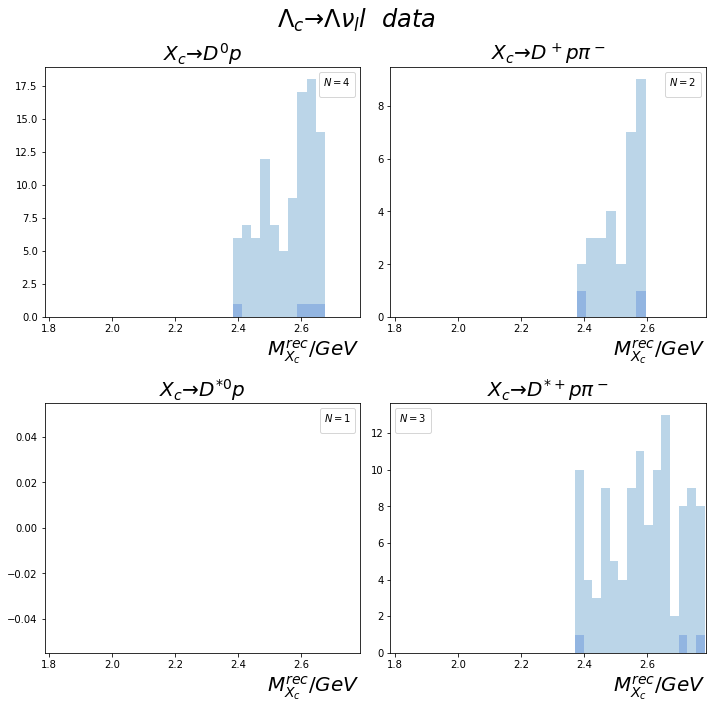

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


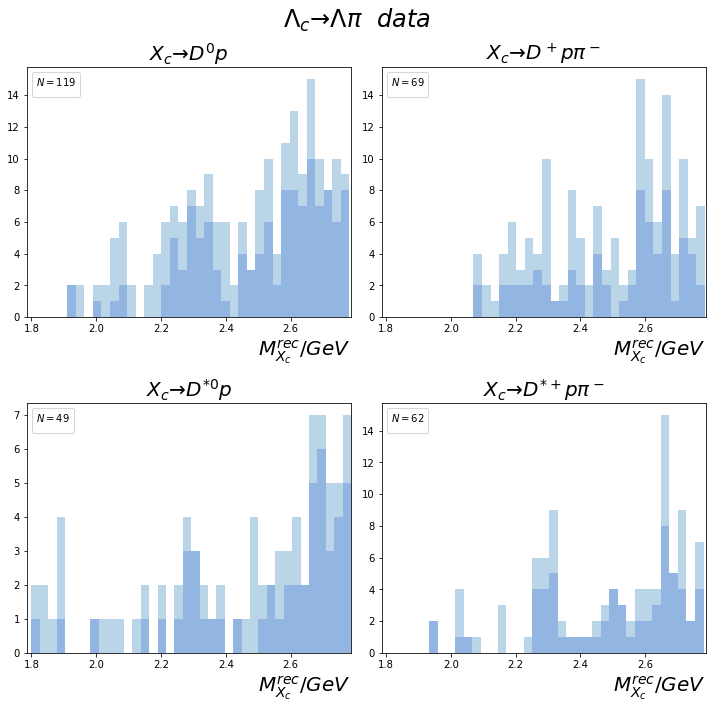

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


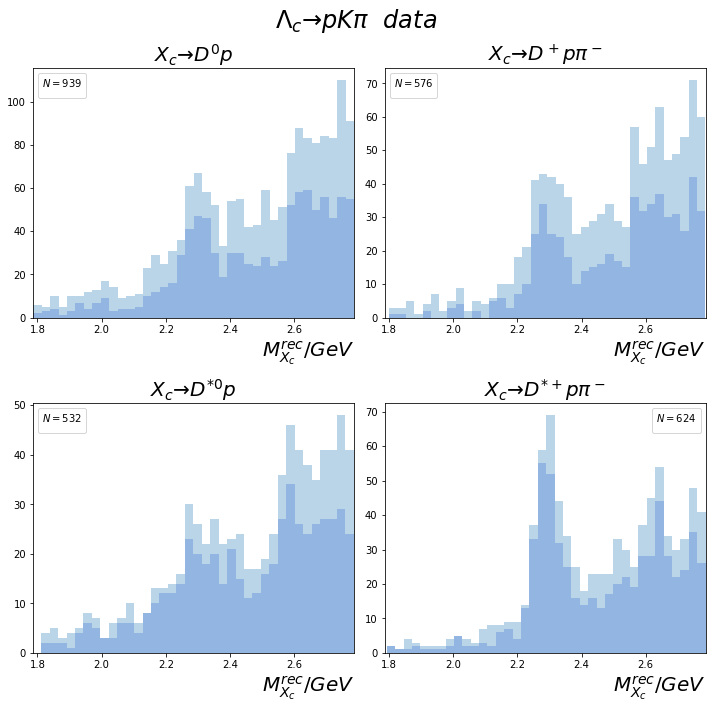

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


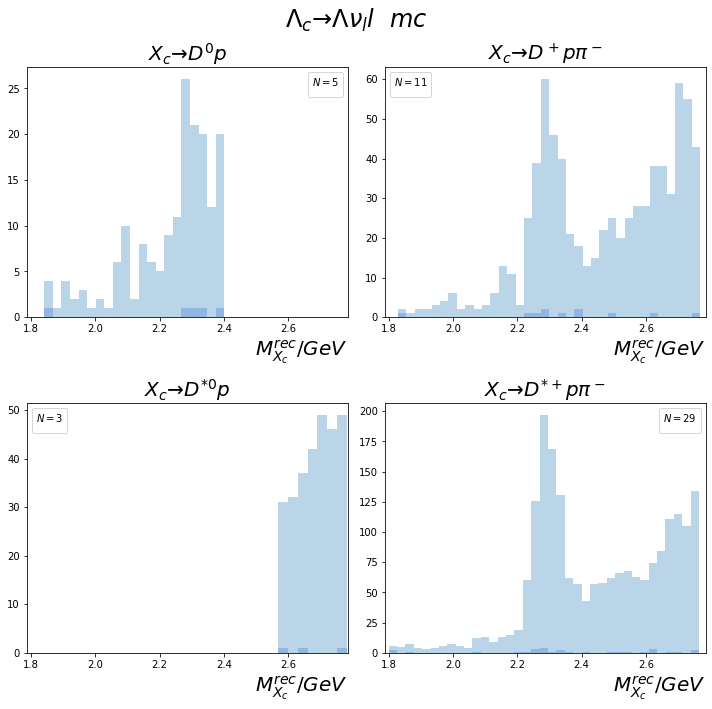

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


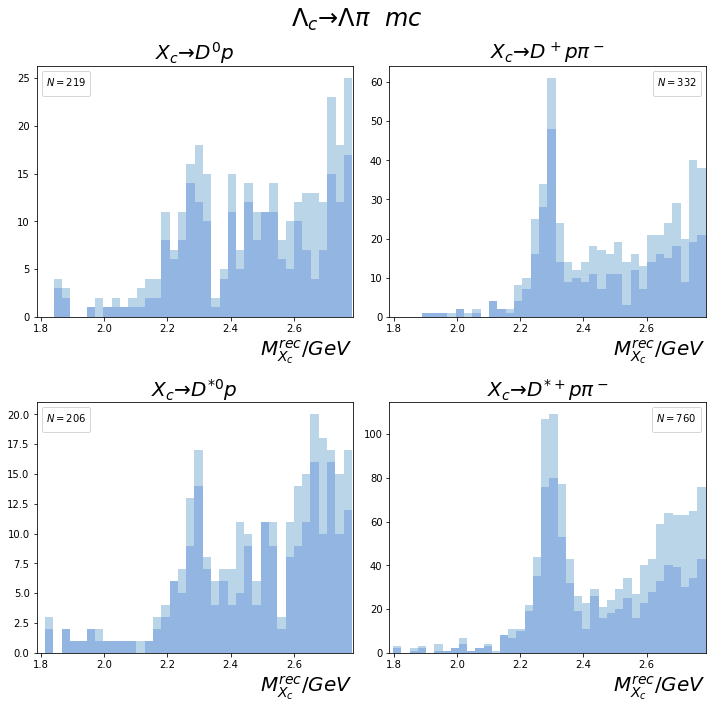

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


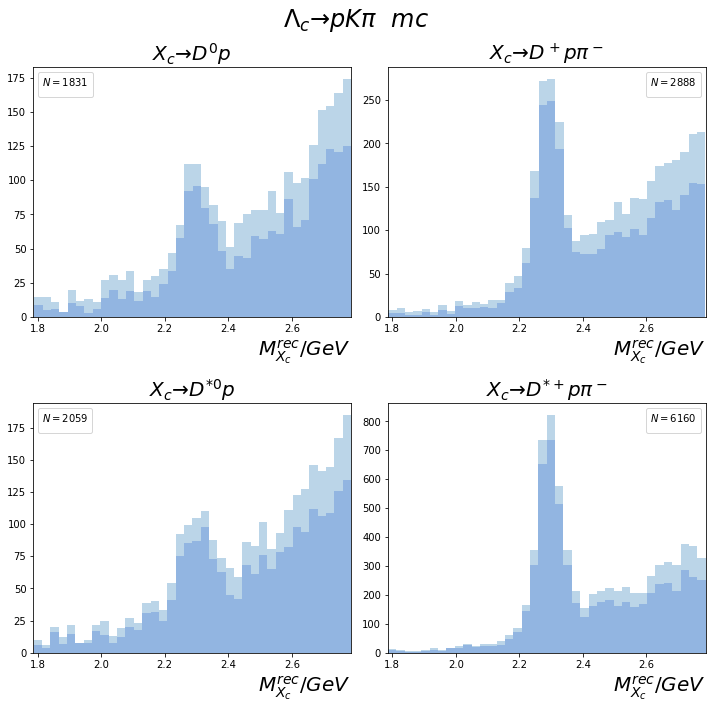

In [ ]:
n = int(np.ceil(chxc**0.5))
wbin = 0.025

for j, dt in enumerate(data):
    for lam_cl, (condition, label) in decay_mod_tag.items():
        fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
        for i in range(chxc):
            dat = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - lamc_mass) < 0.5) & (condition(dt.chlc)) & Lambda_c_mass_mask(dt)]
            datt = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - lamc_mass) < 0.5) & (condition(dt.chlc))]
            diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), int((-min(dat["rm2l"])+max(dat["rm2l"]))/wbin))
            N = dat.shape[0]
            axs[i//n, i%n].legend(title = f"$N = {N}$")
            axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
            axs[i // n, i % n].hist(dat["rm2l"], bins=diw, alpha=0.3, color="royalblue")
            axs[i // n, i % n].hist(datt["rm2l"], bins=diw, alpha=0.3)
            #if j == 1:
            #    dat = dt[(dt.chxc == i + 1) &  (condition(dt.chlc)) & (abs(lamc_mass - dt.rm2l) <= 0.6) & additional_mask & mask]
            #    axs[i // n, i % n].hist(dat["rm2l"], bins=nbins, alpha=0.3, color="dimgray")
            axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')
            axs[i//n, i%n].set_xlim([lamc_mass-0.5, lamc_mass+0.5])

        if j == 0:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ data$", fontsize=24)
            
            fig.savefig(f"{path}{label}_data.png")
        else:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
            fig.savefig(f"{path}{label}_mc.png")
        plt.tight_layout()
        plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


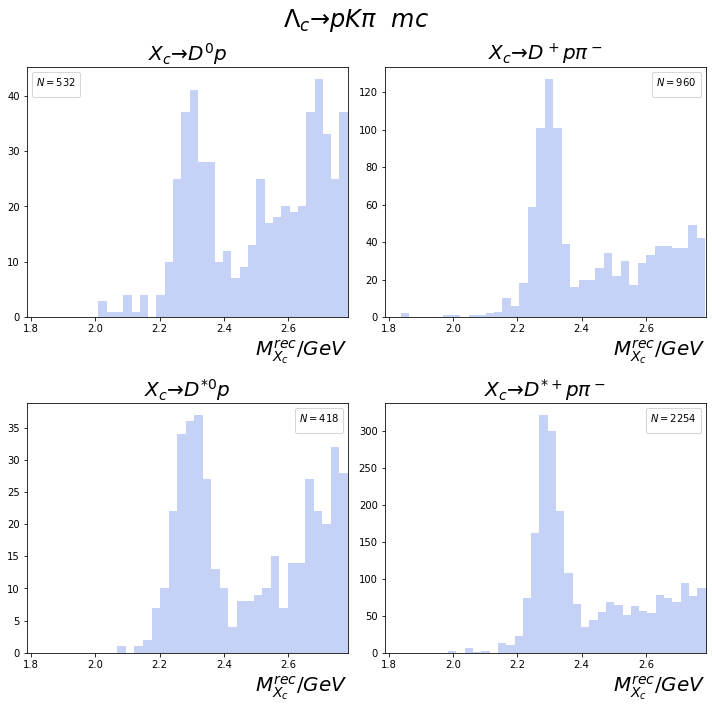

In [ ]:
n = int(np.ceil(chxc**0.5))
wbin = 0.025

j = 1
lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
condition = decay_mod_tag[lam_cl][0]
fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
for i in range(chxc):
    dat = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - lamc_mass) < 0.5) & (condition(dt.chlc)) & (dt.tr_ach) & (dt.tr_lc)]
    diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), int((-min(dat["rm2l"])+max(dat["rm2l"]))/wbin))
    N = dat.shape[0]
    axs[i//n, i%n].legend(title = f"$N = {N}$")
    axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(dat["rm2l"], bins=diw, alpha=0.3, color="royalblue")
    #if j == 1:
    #    dat = dt[(dt.chxc == i + 1) &  (condition(dt.chlc)) & (abs(lamc_mass - dt.rm2l) <= 0.6) & additional_mask & mask]
    #    axs[i // n, i % n].hist(dat["rm2l"], bins=nbins, alpha=0.3, color="dimgray")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')
    axs[i//n, i%n].set_xlim([lamc_mass-0.5, lamc_mass+0.5])

if j == 0:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    
    fig.savefig(f"{path}{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    fig.savefig(f"{path}{label}_re.png")
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


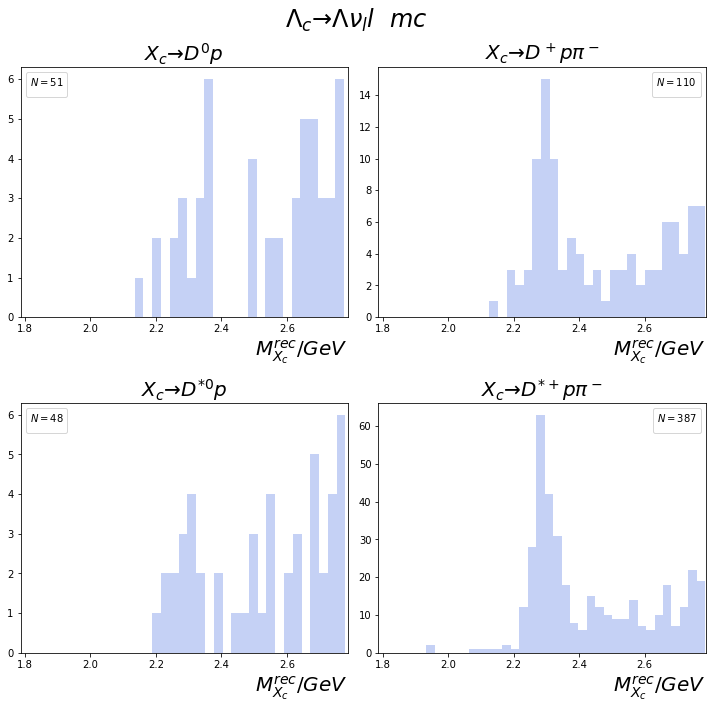

In [ ]:
n = int(np.ceil(chxc**0.5))
wbin = 0.025

j = 1
lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
condition = decay_mod_tag[lam_cl][0]
fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
for i in range(chxc):
    dat = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - lamc_mass) < 0.5) & (condition(dt.chlc)) & (dt.tr_ach) & (dt.tr_lc)]
    diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), int((-min(dat["rm2l"])+max(dat["rm2l"]))/wbin))
    N = dat.shape[0]
    axs[i//n, i%n].legend(title = f"$N = {N}$")
    axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(dat["rm2l"], bins=diw, alpha=0.3, color="royalblue")
    #if j == 1:
    #    dat = dt[(dt.chxc == i + 1) &  (condition(dt.chlc)) & (abs(lamc_mass - dt.rm2l) <= 0.6) & additional_mask & mask]
    #    axs[i // n, i % n].hist(dat["rm2l"], bins=nbins, alpha=0.3, color="dimgray")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')
    axs[i//n, i%n].set_xlim([lamc_mass-0.5, lamc_mass+0.5])

if j == 0:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    
    fig.savefig(f"{path}{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    fig.savefig(f"{path}{label}_re.png")
plt.tight_layout()
plt.show()

In [ ]:

def convolution_meshed(x, g, f, fargs, gargs, delta = 0.1, N = 1000, mesh = None):
    # Оптимизированная функция поиска свертки двух функций опреденных на x
    # Условие применимости 
    # f - синальная функция на X и локализованная в центре X, пик узкий (хотя он может быть не один) если нет то надо расширить S
    # g - функция фонов, определена на S - mean(X)
    # S содержит X-mean(X) так чтобы for all xi in (X-mean(X))/S, x' in x => f(xi-x) << 1
    # Кароче s = [min(x)-delta, max(x)+delta] где delta полуширина пика   
    mu = np.mean(x)
    if not(mesh is None):
        x, s = np.meshgrid(x, mesh)
    else:
        x, s = np.meshgrid(x, np.linspace(np.min(x) - mu - delta, np.max(x) - mu + delta, N))
    return np.sum(g(s, *fargs)*f(x-s, *gargs), axis=0)/N

In [ ]:
sq = njit(lambda x, c1, c2, b1, a1: c1 * np.sqrt((x - pi_mass) * heaviside(x, pi_mass)) * (1 + a1*eval_chebyt(1, x))  + c2 * np.sqrt(x * heaviside(x, 0)) * (1 + b1*eval_chebyt(1, x)))

signal_lam = njit(lambda x, mass1, A2, sigma1, sigma2: A2*gaussian(x, mass1, sigma1) + (1-A2)*gaussian(x, lamc_mass, sigma2))

def continuum_lam(x, mass1, A2, sigma1, sigma2, c0, c1, c2, b1, a1):
    return convolution_meshed(x, sq, signal_lam, [c1, c2, b1, a1], [mass1, A2, sigma1, sigma2], max(sigma1, sigma2)*10, mesh=np.linspace(-1, 1, 700)) + c0

f_lam = lambda x, A1, mass1, A2, sigma1, sigma2, c0, c1, c2, b1, a1: A1*signal_lam(x, mass1, A2, sigma1, sigma2) + (1-A1)*continuum_lam(x, mass1, A2, sigma1, sigma2, c0, c1, c2, b1, a1)

In [ ]:
num_cores = multiprocessing.cpu_count()
print(f"Доступно ядер: {num_cores}")

Доступно ядер: 80


In [ ]:
def process_channel(i, dt, lamc_mass, decay_mod_taging, label, j, res):
    try:
        mask = (dt.chlc <= 2) & (np.abs(dt.rm2l - lamc_mass) < 0.5)

        dat = dt[(dt.chxc == i + 1) & mask]

        counts, bin_edges = np.histogram(dat.rm2l, bins=150)
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

        if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
            args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1]
        else:
            args = (2.5e-01, lamc_mass, 0.1, 1e-02, 1e-02, 1e-01, 5e-01, 5e-01, 0, 0)
        bounds = ((0, 1), (lamc_mass - 0.01, lamc_mass + 0.05), (0, 1), (0, 0.04), (0, 0.04), (0, 2), (0, 2), (0, 2), (-10, 10), (-10, 10))

        args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=bounds)

        ans = {f"fit_{label}_{decay_mod_taging[i]}_{j}" : list([*args, normm])}
        return ans

    except Exception as e:
        return {f"error_{i}": str(e)}

if __name__ == '__main__':
    lam_cl = "\\Lambda \\nu_l l"
    label = decay_mod_tag[lam_cl][1]

    with open('Mat_belle/res.json', 'r') as file:
        res = json.load(file)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    try:
        results = pool.starmap(process_channel, [(i//2, data[i%2], lamc_mass, decay_mod_taging, label, i%2, res) for i in range(2*chxc)])

    except Exception as e:
        print(f"An error occurred during multiprocessing: {e}")

    finally:
        pool.close()
        pool.join()

    for result in results:
        if isinstance(result, dict):
            for key in result:
                if key.startswith("error_"):
                    print(f"Error in channel {key.split('_')[1]}: {result[key]}")
                else:
                    res[key] = result[key]

    with open('Mat_belle/res.json', 'w') as file:
        json.dump(res, file, indent=4)


/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/home/belle2/matrk/.venv/lib64/python3.6/

     fun: 150.27274439481835
     jac: array([ 1.86920166e-04,  1.71852112e-03, -4.95910645e-05, -1.28040314e-02,
       -3.84559631e-02, -2.55584717e-04,  5.34057617e-04,  6.69479370e-04,
        1.02996826e-04,  8.96453857e-05])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.00656014,  2.27646   ,  0.243237  ,  0.04      ,  0.04      ,
        2.        ,  0.4213928 ,  0.40596383, -0.02238002, -0.01898049])

     fun: 150.7235661440215
     jac: array([-2.38418579e-04, -6.35147095e-04, -3.05175781e-05,  1.56402588e-04,
       -1.83868408e-03, -7.62939453e-06, -7.24792480e-05,  3.81469727e-04,
       -3.81469727e-05, -2.67028809e-05])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 9.01265006e-04,  2.29465356e+00,  1.70053115e-01,  3.90114933e-02,
        4.00000000e-02,  1.87388767e+00,  1.85071170e-02,  2.79679117e-0

0.10291502300217525
0.17959600184280877


/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


ValueError: cannot convert float NaN to integer

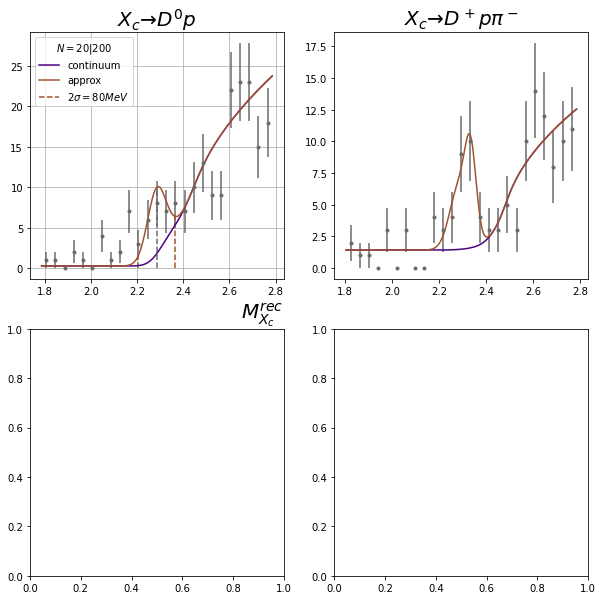

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 0
dt = data[j]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    mask = (dt.chlc <= 2)  & (np.abs(dt.rm2l - lamc_mass) < 0.5) 
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()


if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


0.22080746020685926
0.32440572777805987
0.17505669084966435
0.2289984927451153


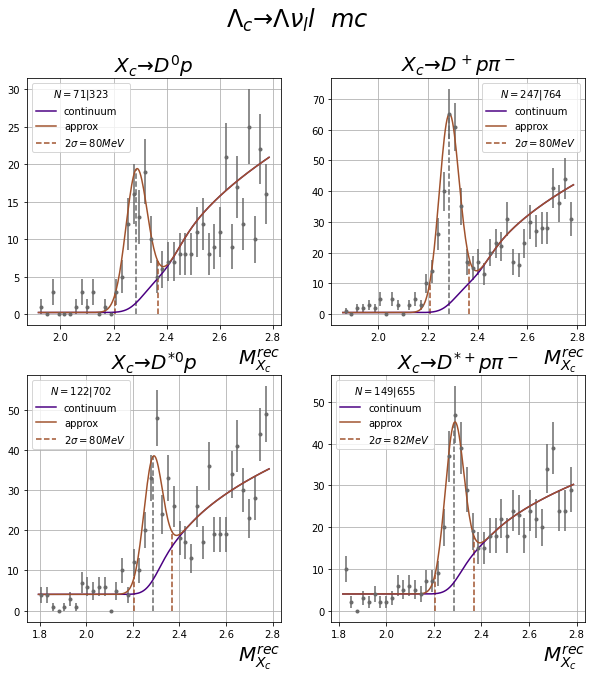

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 1
dt = data[j]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    mask = (dt.chlc <= 2)  & (np.abs(dt.rm2l - lamc_mass) < 0.5) 
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()


if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


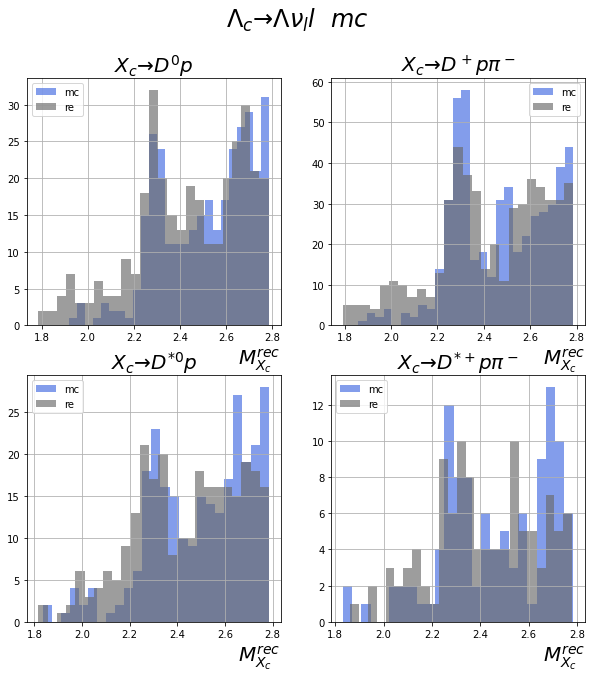

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_re = data[0]
dt_mc = data[1]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]

for i in range(chxc):
    mask_re = (dt_re.chlc <= 2)  & (np.abs(dt_re.rm2l - lamc_mass) < 0.5) 
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5) 
    re = dt_re[(dt.chxc == i + 1) & mask_re].rm2l
    mc = dt_mc[(dt.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


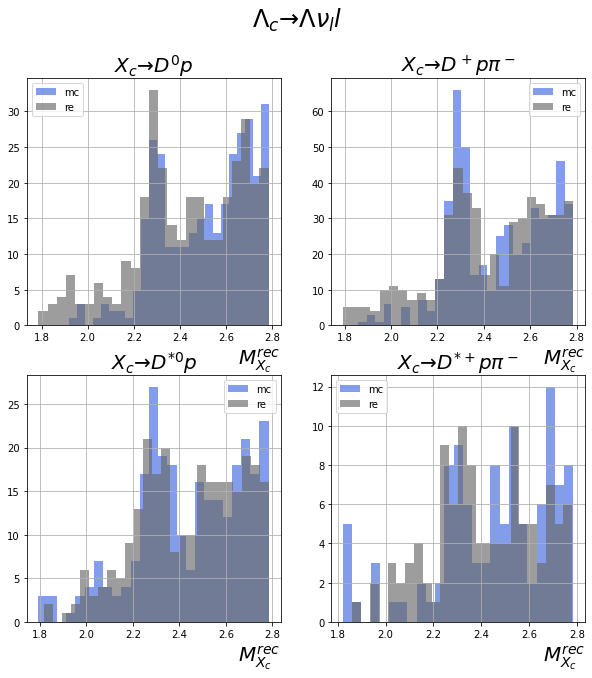

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_re = data[0]
dt_mc = data[1]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]

for i in range(chxc):
    mask_re = (dt_re.chlc <= 2)  & (np.abs(dt_re.rm2l - lamc_mass) < 0.5) 
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5) 
    re = dt_re[(dt.chxc == i + 1) & mask_re].rm2l
    mc = dt_mc[(dt.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()

fig.suptitle(f"$\\Lambda_c \\to {lam_cl}$", fontsize=24)
rm(f"{path}comp_{label}_mc.png")
fig.savefig(f"{path}comp_{label}_mc.png")

plt.show()


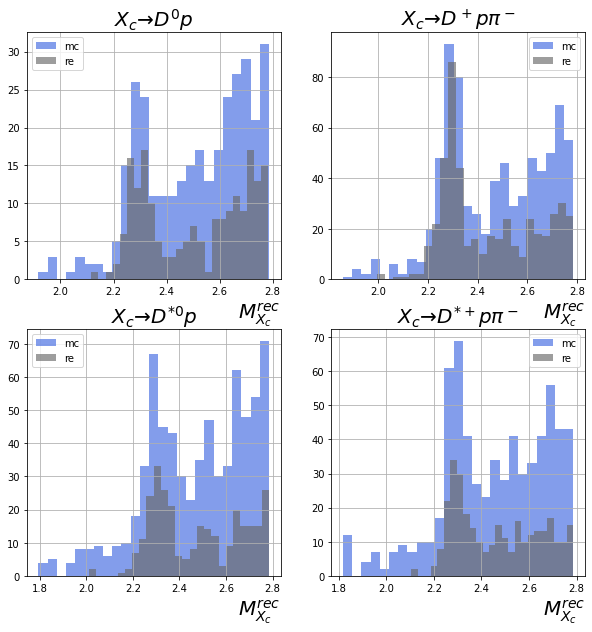

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_mc = data[1]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_mc[(dt_mc.chxc == i + 1) & mask_mc & dt_mc.tr_ach].rm2l
    mc = dt_mc[(dt_mc.chxc == i + 1) & mask_mc].rm2l


    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()

In [ ]:
D_star_0_gamm_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.010) & (dt.chach == 2) & (dt.chxc == 3)
D_star_0_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & (dt.chach == 1) & (dt.chxc == 3)
D_star_pm_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & ((dt.chach == 1) | (dt.chach == 2)) & (dt.chxc == 4)
D_star_mask = lambda dt: D_star_0_gamm_mask(dt) | D_star_0_pi_mask(dt) | D_star_pm_pi_mask(dt) | (dt.chxc == 1) | (dt.chxc == 2)
Lambda_c_mass_mask = lambda dt: np.abs(dt.mlc) < 0.015 
Privalov_cut = lambda dt: (np.abs(dt.p) < 0.05) & (np.abs(dt.e - dt.ecm) < 0.05)

In [ ]:
def process_channel(i, dt, lamc_mass, decay_mod_taging, label, j, res):
    try:
        mask = (dt.chlc == 5) & (np.abs(dt.rm2l - lamc_mass) < 0.5)
        add_mask = D_star_mask(dt) & Lambda_c_mass_mask(dt)

        dat = dt[(dt.chxc == i + 1) & mask ]

        counts, bin_edges = np.histogram(dat.rm2l, bins=150)
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

        if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
            args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1]
        else:
            args = (2.5e-01, lamc_mass, 0.1, 1e-02, 1e-02, 1e-01, 5e-01, 5e-01, 0, 0)
        bounds = ((0, 1), (lamc_mass - 0.01, lamc_mass + 0.05), (0, 1), (0, 0.04), (0, 0.04), (0, 2), (0, 2), (0, 2), (-10, 10), (-10, 10))

        args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=bounds)

        ans = {f"fit_{label}_{decay_mod_taging[i]}_{j}" : list([*args, normm])}
        return ans

    except Exception as e:
        return {f"error_{i}": str(e)}

if __name__ == '__main__':
    lam_cl = "p K \\pi"
    label = decay_mod_tag[lam_cl][1]

    with open('Mat_belle/res.json', 'r') as file:
        res = json.load(file)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    try:
        results = pool.starmap(process_channel, [(i//2, data[i%2], lamc_mass, decay_mod_taging, label, i%2, res) for i in range(2*chxc)])

    except Exception as e:
        print(f"An error occurred during multiprocessing: {e}")

    finally:
        pool.close()
        pool.join()

    for result in results:
        if isinstance(result, dict):
            for key in result:
                if key.startswith("error_"):
                    print(f"Error in channel {key.split('_')[1]}: {result[key]}")
                else:
                    res[key] = result[key]

    with open('Mat_belle/res.json', 'w') as file:
        json.dump(res, file, indent=4)


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/

     fun: 150.1695272179614
     jac: array([ 7.32421875e-04,  1.37329102e-04,  7.62939453e-06, -4.68063354e-03,
       -2.09484100e-02, -1.06811523e-04,  2.80380249e-04,  2.84194946e-04,
        4.38690186e-05,  2.28881836e-05])
 message: 'Optimization terminated successfully'
    nfev: 23
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.01811664,  2.27648489,  0.15213026,  0.04      ,  0.04      ,
        2.        ,  0.29744522,  0.40392893, -0.04442099, -0.03914425])

     fun: 152.3785386681298
     jac: array([ 7.47680664e-04,  2.47955322e-04, -1.90734863e-06, -3.06510925e-03,
       -9.24110413e-03, -4.76837158e-05,  1.31607056e-04,  9.72747803e-05,
        4.00543213e-05,  1.14440918e-05])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 0.0270771 ,  2.27646   ,  0.17835567,  0.04      ,  0.04      ,
        2.        ,  0.15387812,  0.52825255, -0.09676879, -0.10245167])
   

0.2672640442018479
0.3462868751430036
0.1911102932398525
0.2609210749492695


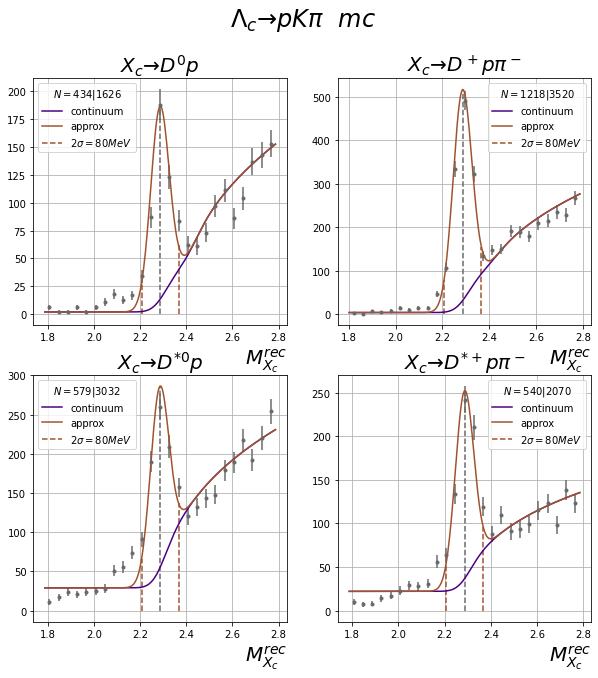

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 1
dt = data[j]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 5)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


0.18620971121421614
0.20321505683312302
0.13229393421773927
0.1415441118606865
The file does not exist


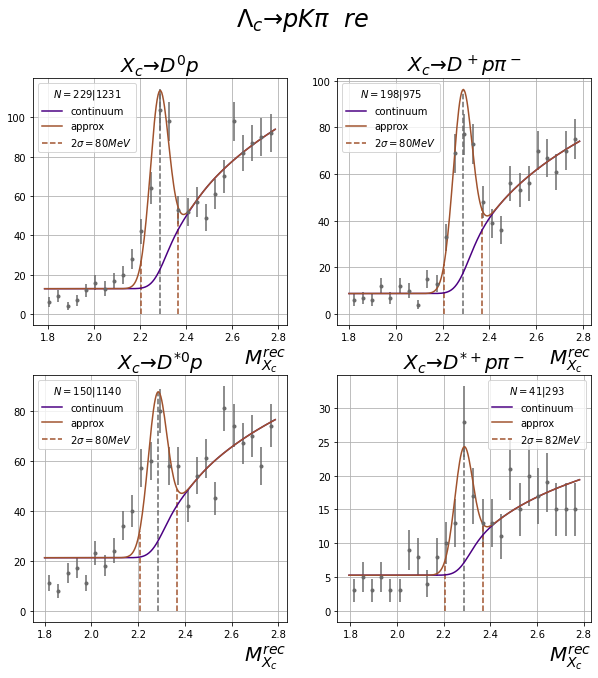

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 0
dt = data[j]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 5)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


The file does not exist


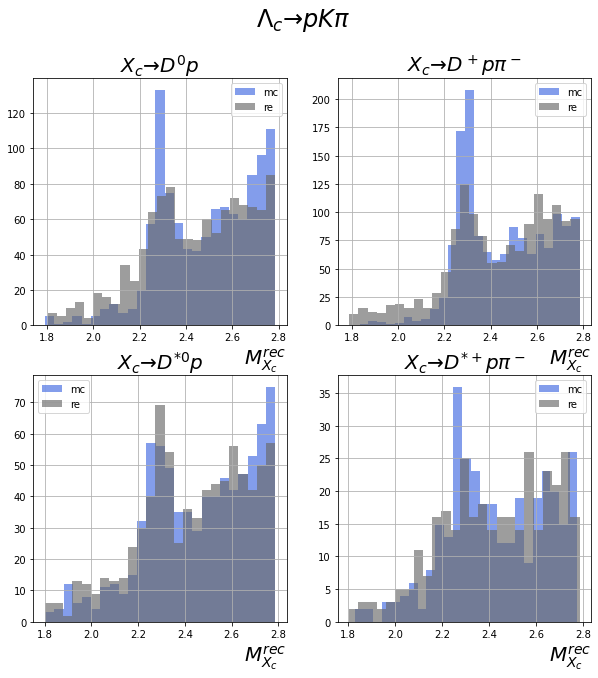

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_re = data[0]
dt_mc = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    mask_re = (dt_re.chlc == 5)  & (np.abs(dt_re.rm2l - lamc_mass) < 0.5)
    mask_mc = (dt_mc.chlc == 5)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_re[(dt.chxc == i + 1) & mask_re].rm2l
    mc = dt_mc[(dt.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()


fig.suptitle(f"$\\Lambda_c \\to {lam_cl}$", fontsize=24)
rm(f"{path}comp_{label}_re.png")
fig.savefig(f"{path}comp_{label}_re.png")



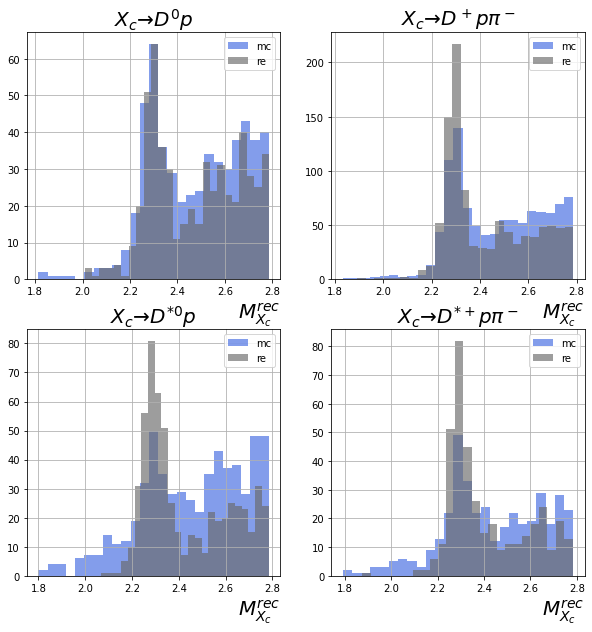

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_mc = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    add_mask_mc = Lambda_c_mass_mask(dt_mc) & D_star_mask(dt_mc)
    mask_mc = (dt_mc.chlc == 5)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_mc[(dt_mc.chxc == i + 1) & mask_mc & dt_mc.tr_ach & dt_mc.tr_lc].rm2l
    mc = dt_mc[(dt_mc.chxc == i + 1) & mask_mc].rm2l


    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()



No handles with labels found to put in legend.
No handles with labels found to put in legend.


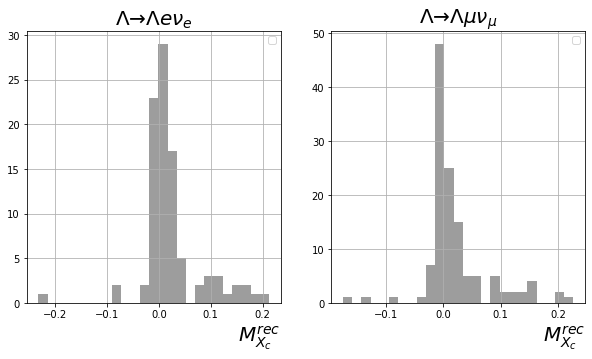

In [ ]:
n = 2
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(1, 2, figsize=(5*n, 5*2//n if 2%n == 0 else 5*(2//n + 1)))
dt_re = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
lmc = ["$\\Lambda \\to \\Lambda e \\nu_e$", "$\\Lambda \\to \\Lambda \\mu \\nu_\\mu$"]

for i in [1, 2]:
    mask_re = (dt_re.chlc == i) & (dt_re.ecm > 0.05) & (np.abs(dt_re.nrm2n) < 0.25) & (dt_re.p > 0.05) & (dt_re.q2 > 0) & (dt_re.q2 < 1.37) & (np.abs(dt_mc.rm2l - 2.29) < 0.1)
    re = dt_re[(dt_re.chxc <= 2) & mask_re].nrm2n

    axs[i-1].set_title(lmc[i-1], fontsize=20)
    axs[i-1].hist(re, bins=nbins, alpha=0.65, color="dimgray")
    axs[i-1].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i-1].legend()
    axs[i-1].grid()



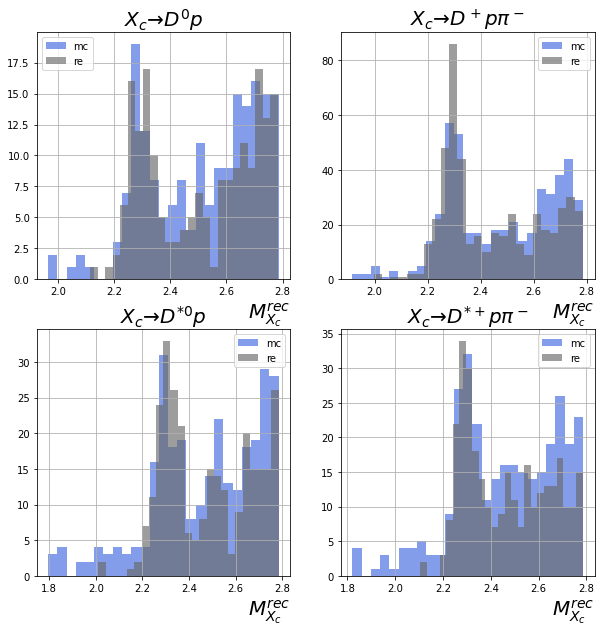

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_mc = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    add_mask_mc = Lambda_c_mass_mask(dt_mc) & D_star_mask(dt_mc)
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_mc[(dt_mc.chxc == i + 1) & mask_mc & dt_mc.tr_ach].rm2l
    mc = dt_mc[(dt_mc.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()



In [ ]:
def process_channel(i, dt, lamc_mass, decay_mod_taging, label, j, res):
    try:
        mask = (dt.chlc == 3) & (np.abs(dt.rm2l - lamc_mass) < 0.5)

        dat = dt[(dt.chxc == i + 1) & mask]

        counts, bin_edges = np.histogram(dat.rm2l, bins=150)
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

        if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
            args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1]
        else:
            args = (2.5e-01, lamc_mass, 0.1, 1e-02, 1e-02, 1e-01, 5e-01, 5e-01, 0, 0)
        bounds = ((0, 1), (lamc_mass - 0.01, lamc_mass + 0.05), (0, 1), (0, 0.04), (0, 0.04), (0, 2), (0, 2), (0, 2), (-10, 10), (-10, 10))

        args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=bounds)

        ans = {f"fit_{label}_{decay_mod_taging[i]}_{j}" : list([*args, normm])}
        return ans

    except Exception as e:
        return {f"error_{i}": str(e)}

if __name__ == '__main__':
    lam_cl = "\\Lambda \\pi"
    label = decay_mod_tag[lam_cl][1]

    with open('Mat_belle/res.json', 'r') as file:
        res = json.load(file)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    try:
        results = pool.starmap(process_channel, [(i//2, data[i%2], lamc_mass, decay_mod_taging, label, i%2, res) for i in range(2*chxc)])

    except Exception as e:
        print(f"An error occurred during multiprocessing: {e}")

    finally:
        pool.close()
        pool.join()

    for result in results:
        if isinstance(result, dict):
            for key in result:
                if key.startswith("error_"):
                    print(f"Error in channel {key.split('_')[1]}: {result[key]}")
                else:
                    res[key] = result[key]

    with open('Mat_belle/res.json', 'w') as file:
        json.dump(res, file, indent=4)


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  


     fun: 162.91250289627138
     jac: array([-4.39643860e-03, -2.02178955e-04,  2.86102295e-05, -7.51495361e-04,
       -6.10542297e-03,  0.00000000e+00,  1.30271912e-03,  1.37329102e-04,
        2.09808350e-05,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 1.02152347e-03,  2.27725753e+00,  8.64212851e-02,  4.00000000e-02,
        3.99881077e-02,  1.92251731e+00,  3.32213147e-15,  3.46125069e-02,
       -1.22756156e-01, -8.52819747e-02])


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  


     fun: 191.07340553166347
     jac: array([ 3.62396240e-05,  8.18252563e-04, -3.81469727e-05, -2.17056274e-03,
       -9.17816162e-03, -3.81469727e-05,  1.67846680e-04,  1.06811523e-04,
        1.52587891e-05, -1.90734863e-06])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.02024073,  2.27646   ,  0.20362938,  0.04      ,  0.04      ,
        2.        ,  0.07335605,  0.66861903, -0.05784597, -0.07332873])

     fun: 175.55890466399484
     jac: array([-6.48498535e-04,  5.21087646e-03, -1.20162964e-04, -1.66358948e-02,
       -3.39012146e-02, -1.81198120e-04,  3.87191772e-04,  3.58581543e-04,
        1.06811523e-04,  5.91278076e-05])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.01401435,  2.27646   ,  0.34556005,  0.04      ,  0.04      ,
        2.        ,  0.3981279 ,  0.61646736, -0.01975225, -0.02801533])
 

0.18398870301224646
0.16415880412761896
0.1517487832816482


0.162963672666674
The file does not exist


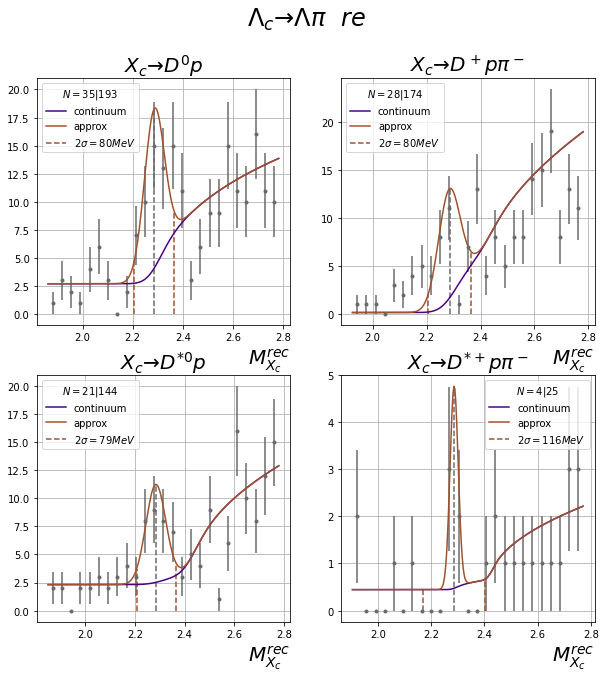

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 0
dt = data[j]

lam_cl = "\\Lambda \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 3)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


0.25781955135662915
0.3172717261307616
0.17185682474057662
0.208083831442198


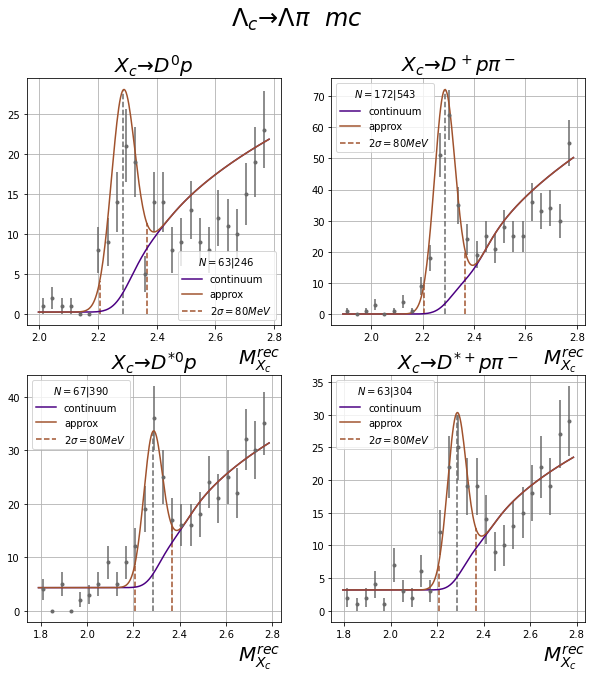

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 1
dt = data[j]

lam_cl = "\\Lambda \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 3)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()
